<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [4]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [5]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# print(config_tickers.DOW_30_TICKER)

In [7]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [11]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [12]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [13]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [14]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [15]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)
e_train_gym_conservative.value_history.shape

(20,)

## Environment for Training



In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [19]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [20]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [21]:
# model_ppo2.load('42')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="6",
                             total_timesteps=3000000)

load
Logging to ppo/6_1
-----------------------------------
| time/              |            |
|    fps             | 117        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.24282552 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012917281 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0051     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.28        |
|    n_updates            | 10          |
|    policy_gradient_l

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 12          |
|    time_elapsed         | 215         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.024812344 |
|    clip_fraction        | 0.261       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.7       |
|    explained_variance   | -0.000251   |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0184     |
|    reward               | -0.29524308 |
|    std                  | 1.02        |
|    value_loss           | 24.9        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3078606.73
total_reward: 2078606.73
total_cost: 302121.29
total_trades: 77532
Sharpe: 0.68

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 22          |
|    time_elapsed         | 395         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.033195082 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.1       |
|    explained_variance   | 0.0107      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.06        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0146     |
|    reward               | 1.4417834   |
|    std                  | 1.04        |
|    value_loss           | 22.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 23 

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 32          |
|    time_elapsed         | 582         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.020327464 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | 0.0194      |
|    learning_rate        | 0.00025     |
|    loss                 | 18.8        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0189     |
|    reward               | -1.8078364  |
|    std                  | 1.05        |
|    value_loss           | 40.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 33    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 42          |
|    time_elapsed         | 767         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.025868943 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | 0.0278      |
|    learning_rate        | 0.00025     |
|    loss                 | 33.9        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0086     |
|    reward               | 0.44194233  |
|    std                  | 1.07        |
|    value_loss           | 79.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 43    

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 52         |
|    time_elapsed         | 949        |
|    total_timesteps      | 106496     |
| train/                  |            |
|    approx_kl            | 0.03932433 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.5      |
|    explained_variance   | 0.0279     |
|    learning_rate        | 0.00025    |
|    loss                 | 34.3       |
|    n_updates            | 510        |
|    policy_gradient_loss | 0.0012     |
|    reward               | -6.074378  |
|    std                  | 1.08       |
|    value_loss           | 94.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 53          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 62          |
|    time_elapsed         | 1131        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.028248373 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0033     |
|    reward               | -0.7624097  |
|    std                  | 1.1         |
|    value_loss           | 81.1        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 112       |
|    iterations           | 63        |


-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 72          |
|    time_elapsed         | 1314        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.024467569 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.0765      |
|    learning_rate        | 0.00025     |
|    loss                 | 36.5        |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.00857    |
|    reward               | -17.590876  |
|    std                  | 1.12        |
|    value_loss           | 67.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 73    

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 82         |
|    time_elapsed         | 1497       |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.05540983 |
|    clip_fraction        | 0.333      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.9      |
|    explained_variance   | 0.00367    |
|    learning_rate        | 0.00025    |
|    loss                 | 42.8       |
|    n_updates            | 810        |
|    policy_gradient_loss | -0.00278   |
|    reward               | 0.12408859 |
|    std                  | 1.14       |
|    value_loss           | 66.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 83          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 92          |
|    time_elapsed         | 1679        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.017805528 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.5       |
|    explained_variance   | 0.033       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.6        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0113     |
|    reward               | -1.6508435  |
|    std                  | 1.16        |
|    value_loss           | 60.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 93    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 102         |
|    time_elapsed         | 1863        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.026721885 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.9       |
|    explained_variance   | -0.000584   |
|    learning_rate        | 0.00025     |
|    loss                 | 55.3        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.0127     |
|    reward               | -1.7270198  |
|    std                  | 1.18        |
|    value_loss           | 114         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 5075340.30
total_reward: 4075340.30
total_cost: 286799.27
total_trades: 73797
Sharpe: 0.845
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 112         |
|    time_elapsed         | 2047        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.028879724 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.4       |
|    explained_variance   | 0.055       |
|    learning_rate        | 0.00025     |
|    loss                 | 109         |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00915    |
|    reward               | -1.0922635  |
|    std                  | 1.2         |
|    value_loss           | 129         |
----------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 122        |
|    time_elapsed         | 2231       |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.02953684 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -46.9      |
|    explained_variance   | 0.0525     |
|    learning_rate        | 0.00025    |
|    loss                 | 55.5       |
|    n_updates            | 1210       |
|    policy_gradient_loss | -0.0109    |
|    reward               | -0.2871872 |
|    std                  | 1.22       |
|    value_loss           | 85.3       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 123        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 132         |
|    time_elapsed         | 2416        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.030467816 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.5       |
|    explained_variance   | 0.178       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.59        |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.0101     |
|    reward               | 0.17711093  |
|    std                  | 1.25        |
|    value_loss           | 22          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 133   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 142         |
|    time_elapsed         | 2599        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.027496496 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.1       |
|    explained_variance   | 0.0109      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.3        |
|    n_updates            | 1410        |
|    policy_gradient_loss | 0.00205     |
|    reward               | -2.3196766  |
|    std                  | 1.27        |
|    value_loss           | 29.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 143

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 152         |
|    time_elapsed         | 2782        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.035046868 |
|    clip_fraction        | 0.339       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.3       |
|    explained_variance   | 0.156       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.9        |
|    n_updates            | 1510        |
|    policy_gradient_loss | 0.00786     |
|    reward               | -1.5402803  |
|    std                  | 1.28        |
|    value_loss           | 46          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 153   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 162         |
|    time_elapsed         | 2965        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.035148673 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.9       |
|    explained_variance   | -0.0167     |
|    learning_rate        | 0.00025     |
|    loss                 | 44.7        |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00719    |
|    reward               | -0.5946616  |
|    std                  | 1.31        |
|    value_loss           | 94.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 163   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 172         |
|    time_elapsed         | 3147        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.026976692 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.4       |
|    explained_variance   | 0.128       |
|    learning_rate        | 0.00025     |
|    loss                 | 33          |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.0021     |
|    reward               | 1.3380725   |
|    std                  | 1.33        |
|    value_loss           | 90.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 182         |
|    time_elapsed         | 3330        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.026555514 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.7       |
|    explained_variance   | 0.101       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.000491   |
|    reward               | -0.21923085 |
|    std                  | 1.35        |
|    value_loss           | 39.2        |
-----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 3146955.02
total_reward: 2146955.02
total_cost: 267109.87
total_trades: 70182
Sharpe: 0.6

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 192        |
|    time_elapsed         | 3516       |
|    total_timesteps      | 393216     |
| train/                  |            |
|    approx_kl            | 0.03419194 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -50.3      |
|    explained_variance   | 0.0502     |
|    learning_rate        | 0.00025    |
|    loss                 | 54.2       |
|    n_updates            | 1910       |
|    policy_gradient_loss | -0.00292   |
|    reward               | -4.326287  |
|    std                  | 1.37       |
|    value_loss           | 80         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 193         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 202         |
|    time_elapsed         | 3699        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.026044969 |
|    clip_fraction        | 0.285       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.9       |
|    explained_variance   | 0.106       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.4        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.0091     |
|    reward               | -9.057119   |
|    std                  | 1.4         |
|    value_loss           | 30.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 212         |
|    time_elapsed         | 3882        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.016640894 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.4       |
|    explained_variance   | 0.07        |
|    learning_rate        | 0.00025     |
|    loss                 | 34.6        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00795    |
|    reward               | 0.22706656  |
|    std                  | 1.43        |
|    value_loss           | 73.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 213   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 222         |
|    time_elapsed         | 4066        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.056594484 |
|    clip_fraction        | 0.388       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.8       |
|    explained_variance   | 0.153       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.4        |
|    n_updates            | 2210        |
|    policy_gradient_loss | 0.000563    |
|    reward               | 0.042779986 |
|    std                  | 1.45        |
|    value_loss           | 54.7        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 223      

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 232         |
|    time_elapsed         | 4248        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.034284886 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.2       |
|    explained_variance   | 0.117       |
|    learning_rate        | 0.00025     |
|    loss                 | 46.4        |
|    n_updates            | 2310        |
|    policy_gradient_loss | 0.0077      |
|    reward               | 0.08712525  |
|    std                  | 1.47        |
|    value_loss           | 59.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 242         |
|    time_elapsed         | 4430        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.020768475 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.7       |
|    explained_variance   | 0.185       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.6        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.00242    |
|    reward               | 0.34687155  |
|    std                  | 1.49        |
|    value_loss           | 61.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 243   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 252         |
|    time_elapsed         | 4613        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.015238994 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.8       |
|    explained_variance   | 0.18        |
|    learning_rate        | 0.00025     |
|    loss                 | 21.5        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.00715    |
|    reward               | 8.828226    |
|    std                  | 1.5         |
|    value_loss           | 56.5        |
-----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 8487400.28
total_reward: 7487400.28
total_cost: 177025.41
total_trades: 60716
Sharpe: 0.9

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 262        |
|    time_elapsed         | 4793       |
|    total_timesteps      | 536576     |
| train/                  |            |
|    approx_kl            | 0.0232923  |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -53.1      |
|    explained_variance   | 0.339      |
|    learning_rate        | 0.00025    |
|    loss                 | 17.8       |
|    n_updates            | 2610       |
|    policy_gradient_loss | -0.00125   |
|    reward               | -1.5778716 |
|    std                  | 1.51       |
|    value_loss           | 33.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 263         |
|    time_el

-------------------------------------------
| time/                   |               |
|    fps                  | 111           |
|    iterations           | 272           |
|    time_elapsed         | 4978          |
|    total_timesteps      | 557056        |
| train/                  |               |
|    approx_kl            | 0.018395226   |
|    clip_fraction        | 0.16          |
|    clip_range           | 0.2           |
|    entropy_loss         | -53.5         |
|    explained_variance   | -0.0264       |
|    learning_rate        | 0.00025       |
|    loss                 | 35.8          |
|    n_updates            | 2710          |
|    policy_gradient_loss | -0.00017      |
|    reward               | -0.0123887705 |
|    std                  | 1.53          |
|    value_loss           | 91.5          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111     

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 7960326.81
total_reward: 6960326.81
total_cost: 166812.96
total_trades: 58064
Sharpe: 0.971
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 282          |
|    time_elapsed         | 5159         |
|    total_timesteps      | 577536       |
| train/                  |              |
|    approx_kl            | 0.0049794344 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -53.9        |
|    explained_variance   | 0.178        |
|    learning_rate        | 0.00025      |
|    loss                 | 59.2         |
|    n_updates            | 2810         |
|    policy_gradient_loss | -0.00186     |
|    reward               | 0.42800766   |
|    std                  | 1.55         |
|    value_loss           | 117          |
--------------------

---------------------------------------
| time/                   |           |
|    fps                  | 111       |
|    iterations           | 292       |
|    time_elapsed         | 5341      |
|    total_timesteps      | 598016    |
| train/                  |           |
|    approx_kl            | 0.0119645 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -53.9     |
|    explained_variance   | 0.201     |
|    learning_rate        | 0.00025   |
|    loss                 | 121       |
|    n_updates            | 2910      |
|    policy_gradient_loss | -0.00564  |
|    reward               | 1.6130822 |
|    std                  | 1.56      |
|    value_loss           | 340       |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 293        |
|    time_elapsed         | 5359    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 302         |
|    time_elapsed         | 5523        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.016971111 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.00025     |
|    loss                 | 139         |
|    n_updates            | 3010        |
|    policy_gradient_loss | -0.00159    |
|    reward               | -8.797205   |
|    std                  | 1.57        |
|    value_loss           | 293         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 303      

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 312         |
|    time_elapsed         | 5705        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.041834764 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.4       |
|    explained_variance   | 0.195       |
|    learning_rate        | 0.00025     |
|    loss                 | 218         |
|    n_updates            | 3110        |
|    policy_gradient_loss | 0.0121      |
|    reward               | -14.434402  |
|    std                  | 1.58        |
|    value_loss           | 251         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 313   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 322         |
|    time_elapsed         | 5887        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.017506856 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55         |
|    explained_variance   | -0.00425    |
|    learning_rate        | 0.00025     |
|    loss                 | 41.8        |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.005      |
|    reward               | -0.2335499  |
|    std                  | 1.62        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 323   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 332          |
|    time_elapsed         | 6069         |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 0.0048370017 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -55.1        |
|    explained_variance   | 0.308        |
|    learning_rate        | 0.00025      |
|    loss                 | 172          |
|    n_updates            | 3310         |
|    policy_gradient_loss | -0.00356     |
|    reward               | 0.5169662    |
|    std                  | 1.62         |
|    value_loss           | 345          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 342         |
|    time_elapsed         | 6254        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.016306862 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.3       |
|    explained_variance   | 0.246       |
|    learning_rate        | 0.00025     |
|    loss                 | 149         |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00507    |
|    reward               | 0.7085312   |
|    std                  | 1.63        |
|    value_loss           | 258         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 343   

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 6661454.38
total_reward: 5661454.38
total_cost: 280826.75
total_trades: 68344
Sharpe: 0.901
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 352         |
|    time_elapsed         | 6436        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.017856466 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.8       |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.00025     |
|    loss                 | 59.1        |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.00623    |
|    reward               | -1.4845273  |
|    std                  | 1.66        |
|    value_loss           | 253         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 362         |
|    time_elapsed         | 6619        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.025401883 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.1       |
|    explained_variance   | 0.127       |
|    learning_rate        | 0.00025     |
|    loss                 | 51          |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.00453    |
|    reward               | 0.045331404 |
|    std                  | 1.68        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 363   

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 372        |
|    time_elapsed         | 6806       |
|    total_timesteps      | 761856     |
| train/                  |            |
|    approx_kl            | 0.02647476 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.3      |
|    explained_variance   | 0.142      |
|    learning_rate        | 0.00025    |
|    loss                 | 56.6       |
|    n_updates            | 3710       |
|    policy_gradient_loss | -0.00407   |
|    reward               | 1.8790717  |
|    std                  | 1.7        |
|    value_loss           | 201        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 373         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 382        |
|    time_elapsed         | 6988       |
|    total_timesteps      | 782336     |
| train/                  |            |
|    approx_kl            | 0.03409986 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.6      |
|    explained_variance   | 0.347      |
|    learning_rate        | 0.00025    |
|    loss                 | 15.5       |
|    n_updates            | 3810       |
|    policy_gradient_loss | -0.00405   |
|    reward               | 1.0131077  |
|    std                  | 1.71       |
|    value_loss           | 33.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 383         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 392         |
|    time_elapsed         | 7170        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.042927064 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.9       |
|    explained_variance   | -0.0425     |
|    learning_rate        | 0.00025     |
|    loss                 | 16.8        |
|    n_updates            | 3910        |
|    policy_gradient_loss | 0.000963    |
|    reward               | 0.1981487   |
|    std                  | 1.73        |
|    value_loss           | 38.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 393   

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 402        |
|    time_elapsed         | 7353       |
|    total_timesteps      | 823296     |
| train/                  |            |
|    approx_kl            | 0.03573095 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.6      |
|    explained_variance   | 0.197      |
|    learning_rate        | 0.00025    |
|    loss                 | 32.7       |
|    n_updates            | 4010       |
|    policy_gradient_loss | -0.00611   |
|    reward               | 1.5236686  |
|    std                  | 1.77       |
|    value_loss           | 53.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 403         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 412         |
|    time_elapsed         | 7535        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.027569711 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.2       |
|    explained_variance   | 0.278       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.8        |
|    n_updates            | 4110        |
|    policy_gradient_loss | 0.00103     |
|    reward               | -1.000815   |
|    std                  | 1.81        |
|    value_loss           | 64.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 422         |
|    time_elapsed         | 7718        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.026095867 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.7       |
|    explained_variance   | 0.00589     |
|    learning_rate        | 0.00025     |
|    loss                 | 188         |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.00969    |
|    reward               | 2.7308762   |
|    std                  | 1.84        |
|    value_loss           | 228         |
-----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 4757038.52
total_reward: 3757038.52
total_cost: 258529.84
total_trades: 65926
Sharpe: 0.7

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 432        |
|    time_elapsed         | 7900       |
|    total_timesteps      | 884736     |
| train/                  |            |
|    approx_kl            | 0.01709301 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -58.9      |
|    explained_variance   | 0.183      |
|    learning_rate        | 0.00025    |
|    loss                 | 56         |
|    n_updates            | 4310       |
|    policy_gradient_loss | -0.0063    |
|    reward               | 1.2831364  |
|    std                  | 1.85       |
|    value_loss           | 133        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 433         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 442         |
|    time_elapsed         | 8081        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.021501964 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.4       |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.00025     |
|    loss                 | 73          |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00552    |
|    reward               | 8.341897    |
|    std                  | 1.89        |
|    value_loss           | 115         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 443   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 452        |
|    time_elapsed         | 8262       |
|    total_timesteps      | 925696     |
| train/                  |            |
|    approx_kl            | 0.01788443 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -59.7      |
|    explained_variance   | 0.142      |
|    learning_rate        | 0.00025    |
|    loss                 | 78.1       |
|    n_updates            | 4510       |
|    policy_gradient_loss | -0.00505   |
|    reward               | -5.1556916 |
|    std                  | 1.9        |
|    value_loss           | 145        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 453         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 462         |
|    time_elapsed         | 8443        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.0203884   |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.1       |
|    explained_variance   | 0.323       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.4        |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.00496    |
|    reward               | -0.41972712 |
|    std                  | 1.93        |
|    value_loss           | 76.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 472         |
|    time_elapsed         | 8625        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.016761402 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.5       |
|    explained_variance   | 0.464       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.4        |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00292    |
|    reward               | 0.0708986   |
|    std                  | 1.96        |
|    value_loss           | 69.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 473

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 482        |
|    time_elapsed         | 8806       |
|    total_timesteps      | 987136     |
| train/                  |            |
|    approx_kl            | 0.01539081 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.8      |
|    explained_variance   | 0.193      |
|    learning_rate        | 0.00025    |
|    loss                 | 49.9       |
|    n_updates            | 4810       |
|    policy_gradient_loss | -0.00482   |
|    reward               | 0.31112495 |
|    std                  | 1.98       |
|    value_loss           | 89.8       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 483          |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 492         |
|    time_elapsed         | 8993        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.030407669 |
|    clip_fraction        | 0.334       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.1       |
|    explained_variance   | 0.209       |
|    learning_rate        | 0.00025     |
|    loss                 | 29.6        |
|    n_updates            | 4910        |
|    policy_gradient_loss | 0.00118     |
|    reward               | 3.719223    |
|    std                  | 2           |
|    value_loss           | 58.7        |
-----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 5089036.65
total_reward: 4089036.65
total_cost: 239357.23
total_trades: 65164
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 502         |
|    time_elapsed         | 9174        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.020611024 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.5       |
|    explained_variance   | 0.2         |
|    learning_rate        | 0.00025     |
|    loss                 | 24.1        |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.00774    |
|    reward               | 1.6350849   |
|    std                  | 2.03        |
|    value_loss           | 46.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 503   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 512         |
|    time_elapsed         | 9355        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.029069163 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.1       |
|    explained_variance   | 0.0135      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.46        |
|    n_updates            | 5110        |
|    policy_gradient_loss | 0.00381     |
|    reward               | -0.9447293  |
|    std                  | 2.08        |
|    value_loss           | 23.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 513   

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 6343434.53
total_reward: 5343434.53
total_cost: 262042.55
total_trades: 66836
Sharpe: 0.989
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 522         |
|    time_elapsed         | 9537        |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.023890426 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.5       |
|    explained_variance   | 0.209       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.4        |
|    n_updates            | 5210        |
|    policy_gradient_loss | -0.00227    |
|    reward               | 0.6819852   |
|    std                  | 2.1         |
|    value_loss           | 30.6        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 532         |
|    time_elapsed         | 9719        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.010820545 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.9       |
|    explained_variance   | 0.351       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.4        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00546    |
|    reward               | 2.9430964   |
|    std                  | 2.13        |
|    value_loss           | 35          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 533   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 542        |
|    time_elapsed         | 9900       |
|    total_timesteps      | 1110016    |
| train/                  |            |
|    approx_kl            | 0.01714696 |
|    clip_fraction        | 0.0896     |
|    clip_range           | 0.2        |
|    entropy_loss         | -63.2      |
|    explained_variance   | 0.214      |
|    learning_rate        | 0.00025    |
|    loss                 | 61.3       |
|    n_updates            | 5410       |
|    policy_gradient_loss | -0.00279   |
|    reward               | 3.926596   |
|    std                  | 2.15       |
|    value_loss           | 157        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 543         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 552         |
|    time_elapsed         | 10082       |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.030740455 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.5       |
|    explained_variance   | 0.0522      |
|    learning_rate        | 0.00025     |
|    loss                 | 53.3        |
|    n_updates            | 5510        |
|    policy_gradient_loss | 0.0038      |
|    reward               | 2.352387    |
|    std                  | 2.17        |
|    value_loss           | 177         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 553   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 562         |
|    time_elapsed         | 10264       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.024370812 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.7       |
|    explained_variance   | 0.175       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.6        |
|    n_updates            | 5610        |
|    policy_gradient_loss | 0.000135    |
|    reward               | 1.8843703   |
|    std                  | 2.19        |
|    value_loss           | 75.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 563   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 572         |
|    time_elapsed         | 10448       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.013051658 |
|    clip_fraction        | 0.0802      |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.3       |
|    explained_variance   | 0.354       |
|    learning_rate        | 0.00025     |
|    loss                 | 60.3        |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.00705    |
|    reward               | -6.007149   |
|    std                  | 2.24        |
|    value_loss           | 170         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 573   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 582         |
|    time_elapsed         | 10630       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.014981583 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.6       |
|    explained_variance   | 0.401       |
|    learning_rate        | 0.00025     |
|    loss                 | 64.7        |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.00654    |
|    reward               | -1.5250275  |
|    std                  | 2.26        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 583   

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 6588258.53
total_reward: 5588258.53
total_cost: 286849.95
total_trades: 68043
Sharpe: 0.944
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 592         |
|    time_elapsed         | 10813       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.012101398 |
|    clip_fraction        | 0.0812      |
|    clip_range           | 0.2         |
|    entropy_loss         | -65         |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.00025     |
|    loss                 | 147         |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.0041     |
|    reward               | 0.12491215  |
|    std                  | 2.29        |
|    value_loss           | 196         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 602         |
|    time_elapsed         | 10997       |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.021818103 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.3       |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.00025     |
|    loss                 | 56          |
|    n_updates            | 6010        |
|    policy_gradient_loss | -0.00807    |
|    reward               | 1.3625171   |
|    std                  | 2.32        |
|    value_loss           | 118         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 603   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 612        |
|    time_elapsed         | 11179      |
|    total_timesteps      | 1253376    |
| train/                  |            |
|    approx_kl            | 0.02299693 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -65.8      |
|    explained_variance   | 0.184      |
|    learning_rate        | 0.00025    |
|    loss                 | 90         |
|    n_updates            | 6110       |
|    policy_gradient_loss | -0.00717   |
|    reward               | 3.2134159  |
|    std                  | 2.36       |
|    value_loss           | 103        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 613         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 622         |
|    time_elapsed         | 11360       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.019113991 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.3       |
|    explained_variance   | 0.166       |
|    learning_rate        | 0.00025     |
|    loss                 | 13          |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.00667    |
|    reward               | 0.10360431  |
|    std                  | 2.4         |
|    value_loss           | 133         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 623   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 632         |
|    time_elapsed         | 11542       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.030063534 |
|    clip_fraction        | 0.299       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.8       |
|    explained_variance   | 0.147       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.6        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.0115     |
|    reward               | -0.12683824 |
|    std                  | 2.44        |
|    value_loss           | 22.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 633      

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 642         |
|    time_elapsed         | 11732       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.026309837 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.1       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.78        |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.00711    |
|    reward               | 1.8431044   |
|    std                  | 2.47        |
|    value_loss           | 22          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 643   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 652         |
|    time_elapsed         | 11914       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.023475919 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.7       |
|    explained_variance   | 0.0524      |
|    learning_rate        | 0.00025     |
|    loss                 | 34          |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.00188    |
|    reward               | 1.2393299   |
|    std                  | 2.52        |
|    value_loss           | 62.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 662         |
|    time_elapsed         | 12096       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.01780273  |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.1       |
|    explained_variance   | 0.0642      |
|    learning_rate        | 0.00025     |
|    loss                 | 31          |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.00798    |
|    reward               | 0.065795235 |
|    std                  | 2.56        |
|    value_loss           | 82.3        |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 6867782.45
total_reward: 5867782.45
total_cost: 303172.30
total_trades: 67905
Sharpe: 0.9

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 672         |
|    time_elapsed         | 12280       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.011049578 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.5       |
|    explained_variance   | 0.26        |
|    learning_rate        | 0.00025     |
|    loss                 | 86.1        |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.00714    |
|    reward               | 0.8271587   |
|    std                  | 2.59        |
|    value_loss           | 132         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 673   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 682          |
|    time_elapsed         | 12462        |
|    total_timesteps      | 1396736      |
| train/                  |              |
|    approx_kl            | 0.0156177115 |
|    clip_fraction        | 0.202        |
|    clip_range           | 0.2          |
|    entropy_loss         | -68.8        |
|    explained_variance   | 0.205        |
|    learning_rate        | 0.00025      |
|    loss                 | 75.1         |
|    n_updates            | 6810         |
|    policy_gradient_loss | -0.00648     |
|    reward               | 2.298221     |
|    std                  | 2.62         |
|    value_loss           | 194          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 692         |
|    time_elapsed         | 12646       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.022987276 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.5       |
|    explained_variance   | 0.146       |
|    learning_rate        | 0.00025     |
|    loss                 | 58.7        |
|    n_updates            | 6910        |
|    policy_gradient_loss | -0.00852    |
|    reward               | 1.8680915   |
|    std                  | 2.69        |
|    value_loss           | 162         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 693   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 702         |
|    time_elapsed         | 12829       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.015357887 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.9       |
|    explained_variance   | 0.199       |
|    learning_rate        | 0.00025     |
|    loss                 | 54.9        |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00635    |
|    reward               | 5.00736     |
|    std                  | 2.72        |
|    value_loss           | 120         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 703   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 712         |
|    time_elapsed         | 13012       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.01777308  |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.4       |
|    explained_variance   | 0.188       |
|    learning_rate        | 0.00025     |
|    loss                 | 61.2        |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.0111     |
|    reward               | -0.33497837 |
|    std                  | 2.77        |
|    value_loss           | 79.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 713

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 722         |
|    time_elapsed         | 13195       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.014516445 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.8       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.2        |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00937    |
|    reward               | -3.66419    |
|    std                  | 2.82        |
|    value_loss           | 72.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 723   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 732        |
|    time_elapsed         | 13377      |
|    total_timesteps      | 1499136    |
| train/                  |            |
|    approx_kl            | 0.00928467 |
|    clip_fraction        | 0.0871     |
|    clip_range           | 0.2        |
|    entropy_loss         | -71.2      |
|    explained_variance   | 0.354      |
|    learning_rate        | 0.00025    |
|    loss                 | 63.8       |
|    n_updates            | 7310       |
|    policy_gradient_loss | -0.00633   |
|    reward               | 0.08496167 |
|    std                  | 2.85       |
|    value_loss           | 102        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 733          |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 742          |
|    time_elapsed         | 13558        |
|    total_timesteps      | 1519616      |
| train/                  |              |
|    approx_kl            | 0.014176615  |
|    clip_fraction        | 0.0934       |
|    clip_range           | 0.2          |
|    entropy_loss         | -71.7        |
|    explained_variance   | 0.096        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.2         |
|    n_updates            | 7410         |
|    policy_gradient_loss | -0.00887     |
|    reward               | -0.060561236 |
|    std                  | 2.9          |
|    value_loss           | 118          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 752         |
|    time_elapsed         | 13740       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.010209238 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.1       |
|    explained_variance   | 0.565       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.8        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00862    |
|    reward               | -1.0766516  |
|    std                  | 2.94        |
|    value_loss           | 76.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 753   

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 3253252.46
total_reward: 2253252.46
total_cost: 190586.26
total_trades: 60684
Sharpe: 0.535
---------------------------------------
| time/                   |           |
|    fps                  | 112       |
|    iterations           | 762       |
|    time_elapsed         | 13922     |
|    total_timesteps      | 1560576   |
| train/                  |           |
|    approx_kl            | 0.0178869 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -72.3     |
|    explained_variance   | 0.00966   |
|    learning_rate        | 0.00025   |
|    loss                 | 18.4      |
|    n_updates            | 7610      |
|    policy_gradient_loss | -0.0122   |
|    reward               | 5.471556  |
|    std                  | 2.96      |
|    value_loss           | 43.7      |
---------------------------------------
-------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 772         |
|    time_elapsed         | 14104       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.010934664 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.5       |
|    explained_variance   | 0.0933      |
|    learning_rate        | 0.00025     |
|    loss                 | 34.2        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.00473    |
|    reward               | -1.2575563  |
|    std                  | 2.98        |
|    value_loss           | 57.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 773

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 782        |
|    time_elapsed         | 14285      |
|    total_timesteps      | 1601536    |
| train/                  |            |
|    approx_kl            | 0.0157918  |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.8      |
|    explained_variance   | 0.369      |
|    learning_rate        | 0.00025    |
|    loss                 | 26.3       |
|    n_updates            | 7810       |
|    policy_gradient_loss | -0.00241   |
|    reward               | -1.1502758 |
|    std                  | 3.02       |
|    value_loss           | 48.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 783         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 792         |
|    time_elapsed         | 14466       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.007942351 |
|    clip_fraction        | 0.0539      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73         |
|    explained_variance   | 0.525       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.4        |
|    n_updates            | 7910        |
|    policy_gradient_loss | -0.00505    |
|    reward               | 2.145385    |
|    std                  | 3.04        |
|    value_loss           | 42.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 793   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 802         |
|    time_elapsed         | 14647       |
|    total_timesteps      | 1642496     |
| train/                  |             |
|    approx_kl            | 0.006890959 |
|    clip_fraction        | 0.0209      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.4       |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.00025     |
|    loss                 | 38          |
|    n_updates            | 8010        |
|    policy_gradient_loss | -0.00286    |
|    reward               | -0.63127434 |
|    std                  | 3.08        |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 803   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 812        |
|    time_elapsed         | 14828      |
|    total_timesteps      | 1662976    |
| train/                  |            |
|    approx_kl            | 0.01870294 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.5      |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.00025    |
|    loss                 | 25         |
|    n_updates            | 8110       |
|    policy_gradient_loss | -0.00066   |
|    reward               | 3.388636   |
|    std                  | 3.1        |
|    value_loss           | 57.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 813         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 822        |
|    time_elapsed         | 15009      |
|    total_timesteps      | 1683456    |
| train/                  |            |
|    approx_kl            | 0.00906796 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.8      |
|    explained_variance   | 0.554      |
|    learning_rate        | 0.00025    |
|    loss                 | 29.9       |
|    n_updates            | 8210       |
|    policy_gradient_loss | -0.00595   |
|    reward               | 3.4614248  |
|    std                  | 3.13       |
|    value_loss           | 88.1       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 823          |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 832         |
|    time_elapsed         | 15200       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.008839907 |
|    clip_fraction        | 0.0511      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.1       |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.00025     |
|    loss                 | 21.4        |
|    n_updates            | 8310        |
|    policy_gradient_loss | -0.00784    |
|    reward               | -3.6407573  |
|    std                  | 3.16        |
|    value_loss           | 43.2        |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 1871754.19
total_reward: 871754.19
total_cost: 168900.42
total_trades: 57776
Sharpe: 0.34

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 842         |
|    time_elapsed         | 15382       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.012092716 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.4       |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.3        |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.0051     |
|    reward               | -3.3298423  |
|    std                  | 3.19        |
|    value_loss           | 35.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 843   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 852         |
|    time_elapsed         | 15564       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.016911846 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.9       |
|    explained_variance   | 0.467       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.6        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.0041     |
|    reward               | -1.9097992  |
|    std                  | 3.24        |
|    value_loss           | 68.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 853      

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 862         |
|    time_elapsed         | 15746       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.017793128 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.2       |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.7        |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.00798    |
|    reward               | -2.773258   |
|    std                  | 3.28        |
|    value_loss           | 46.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 863   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 872         |
|    time_elapsed         | 15929       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.019125443 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.7       |
|    explained_variance   | 0.325       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.8        |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.0127     |
|    reward               | 1.7847638   |
|    std                  | 3.33        |
|    value_loss           | 92.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 873   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 882         |
|    time_elapsed         | 16113       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.018134303 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.9       |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.3        |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.00598    |
|    reward               | -0.25020263 |
|    std                  | 3.36        |
|    value_loss           | 69.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 883   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 892         |
|    time_elapsed         | 16294       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.022161607 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.4       |
|    explained_variance   | 0.324       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.27        |
|    n_updates            | 8910        |
|    policy_gradient_loss | -0.0103     |
|    reward               | 0.8039108   |
|    std                  | 3.42        |
|    value_loss           | 23.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 893

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 902         |
|    time_elapsed         | 16477       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.014585793 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.8       |
|    explained_variance   | 0.442       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.6        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.0122     |
|    reward               | -0.80240154 |
|    std                  | 3.47        |
|    value_loss           | 32.6        |
-----------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 2715211.90
total_reward: 1715211.90
total_cost: 187205.48
total_trades: 58907
Sharpe: 0.4

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 912         |
|    time_elapsed         | 16660       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.014662043 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.423       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.2        |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.00662    |
|    reward               | 3.2730484   |
|    std                  | 3.5         |
|    value_loss           | 47          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 913   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 922         |
|    time_elapsed         | 16841       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.007968251 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.4       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.00025     |
|    loss                 | 40.6        |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.0054     |
|    reward               | 0.9911164   |
|    std                  | 3.54        |
|    value_loss           | 145         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 923   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 932         |
|    time_elapsed         | 17023       |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.010064599 |
|    clip_fraction        | 0.0663      |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.114       |
|    learning_rate        | 0.00025     |
|    loss                 | 80.9        |
|    n_updates            | 9310        |
|    policy_gradient_loss | -0.00586    |
|    reward               | -0.17330992 |
|    std                  | 3.61        |
|    value_loss           | 174         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 933   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 942         |
|    time_elapsed         | 17205       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.012578218 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.3       |
|    explained_variance   | 0.373       |
|    learning_rate        | 0.00025     |
|    loss                 | 41.3        |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.00751    |
|    reward               | 5.2475905   |
|    std                  | 3.65        |
|    value_loss           | 132         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 943   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 952         |
|    time_elapsed         | 17394       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.014436698 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.7       |
|    explained_variance   | 0.382       |
|    learning_rate        | 0.00025     |
|    loss                 | 72.1        |
|    n_updates            | 9510        |
|    policy_gradient_loss | -0.0111     |
|    reward               | 7.1278625   |
|    std                  | 3.71        |
|    value_loss           | 119         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 953   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 962          |
|    time_elapsed         | 17583        |
|    total_timesteps      | 1970176      |
| train/                  |              |
|    approx_kl            | 0.0108361095 |
|    clip_fraction        | 0.125        |
|    clip_range           | 0.2          |
|    entropy_loss         | -79.1        |
|    explained_variance   | 0.63         |
|    learning_rate        | 0.00025      |
|    loss                 | 36.9         |
|    n_updates            | 9610         |
|    policy_gradient_loss | -0.0107      |
|    reward               | -0.06896325  |
|    std                  | 3.76         |
|    value_loss           | 109          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 972         |
|    time_elapsed         | 17772       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.008901713 |
|    clip_fraction        | 0.0904      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.6       |
|    explained_variance   | 0.549       |
|    learning_rate        | 0.00025     |
|    loss                 | 91.7        |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.00861    |
|    reward               | 0.9616664   |
|    std                  | 3.82        |
|    value_loss           | 140         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 973   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 982         |
|    time_elapsed         | 17962       |
|    total_timesteps      | 2011136     |
| train/                  |             |
|    approx_kl            | 0.0086774   |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.9       |
|    explained_variance   | 0.278       |
|    learning_rate        | 0.00025     |
|    loss                 | 57.8        |
|    n_updates            | 9810        |
|    policy_gradient_loss | -0.00842    |
|    reward               | -0.04677628 |
|    std                  | 3.86        |
|    value_loss           | 181         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 983   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 992         |
|    time_elapsed         | 18150       |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.016116474 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.2       |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.00025     |
|    loss                 | 133         |
|    n_updates            | 9910        |
|    policy_gradient_loss | -0.00792    |
|    reward               | -1.8970546  |
|    std                  | 3.9         |
|    value_loss           | 236         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 993   

day: 2892, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 9401939.45
total_reward: 8401939.45
total_cost: 189097.92
total_trades: 59039
Sharpe: 0.995
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1002        |
|    time_elapsed         | 18339       |
|    total_timesteps      | 2052096     |
| train/                  |             |
|    approx_kl            | 0.010855235 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.6       |
|    explained_variance   | 0.639       |
|    learning_rate        | 0.00025     |
|    loss                 | 71          |
|    n_updates            | 10010       |
|    policy_gradient_loss | -0.00909    |
|    reward               | -1.0128304  |
|    std                  | 3.96        |
|    value_loss           | 193         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1012        |
|    time_elapsed         | 18526       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.013017598 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81         |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.7        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.00633    |
|    reward               | -0.82170695 |
|    std                  | 4.01        |
|    value_loss           | 40.5        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1013     

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1022        |
|    time_elapsed         | 18713       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.012897406 |
|    clip_fraction        | 0.0897      |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.3       |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.5        |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.00831    |
|    reward               | -1.5941358  |
|    std                  | 4.06        |
|    value_loss           | 61.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1023  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1032        |
|    time_elapsed         | 18901       |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.009462163 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.7       |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.1        |
|    n_updates            | 10310       |
|    policy_gradient_loss | -0.00476    |
|    reward               | 1.2473266   |
|    std                  | 4.12        |
|    value_loss           | 74          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1033  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1042        |
|    time_elapsed         | 19088       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.010465307 |
|    clip_fraction        | 0.0874      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.1       |
|    explained_variance   | 0.766       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.2        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.0075     |
|    reward               | -0.9894307  |
|    std                  | 4.17        |
|    value_loss           | 89.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1052        |
|    time_elapsed         | 19275       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.010596838 |
|    clip_fraction        | 0.0966      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.4       |
|    explained_variance   | 0.538       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.7        |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.00626    |
|    reward               | -0.66884404 |
|    std                  | 4.22        |
|    value_loss           | 196         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1053  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1062        |
|    time_elapsed         | 19475       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.008429445 |
|    clip_fraction        | 0.0599      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.9       |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.00025     |
|    loss                 | 75.9        |
|    n_updates            | 10610       |
|    policy_gradient_loss | -0.00747    |
|    reward               | -4.8045497  |
|    std                  | 4.29        |
|    value_loss           | 226         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1063  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1072        |
|    time_elapsed         | 19663       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.010634622 |
|    clip_fraction        | 0.0872      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.3       |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.00025     |
|    loss                 | 74.7        |
|    n_updates            | 10710       |
|    policy_gradient_loss | -0.00632    |
|    reward               | 11.716282   |
|    std                  | 4.35        |
|    value_loss           | 271         |
-----------------------------------------
day: 2892, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 10392368.18
total_reward: 9392368.18
total_cost: 158685.27
total_trades: 58581
Sharpe: 1.

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1082         |
|    time_elapsed         | 19854        |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0151121635 |
|    clip_fraction        | 0.124        |
|    clip_range           | 0.2          |
|    entropy_loss         | -83.7        |
|    explained_variance   | 0.684        |
|    learning_rate        | 0.00025      |
|    loss                 | 135          |
|    n_updates            | 10810        |
|    policy_gradient_loss | -0.0049      |
|    reward               | -0.9731553   |
|    std                  | 4.42         |
|    value_loss           | 380          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1092        |
|    time_elapsed         | 20043       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.008318246 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.2       |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.00025     |
|    loss                 | 138         |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.00712    |
|    reward               | -1.1168641  |
|    std                  | 4.5         |
|    value_loss           | 347         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1093  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1102        |
|    time_elapsed         | 20232       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.008603337 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.6       |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.00025     |
|    loss                 | 140         |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.00843    |
|    reward               | 0.43911317  |
|    std                  | 4.56        |
|    value_loss           | 249         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1103  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1112        |
|    time_elapsed         | 20421       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.011025848 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.9       |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.00025     |
|    loss                 | 232         |
|    n_updates            | 11110       |
|    policy_gradient_loss | -0.00945    |
|    reward               | -1.6202753  |
|    std                  | 4.62        |
|    value_loss           | 242         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1113  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1122        |
|    time_elapsed         | 20610       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.014367746 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.3       |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.00025     |
|    loss                 | 258         |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.00794    |
|    reward               | 0.19765846  |
|    std                  | 4.68        |
|    value_loss           | 261         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1123  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1132         |
|    time_elapsed         | 20801        |
|    total_timesteps      | 2318336      |
| train/                  |              |
|    approx_kl            | 0.010638665  |
|    clip_fraction        | 0.0729       |
|    clip_range           | 0.2          |
|    entropy_loss         | -85.6        |
|    explained_variance   | 0.609        |
|    learning_rate        | 0.00025      |
|    loss                 | 78.1         |
|    n_updates            | 11310        |
|    policy_gradient_loss | -0.00695     |
|    reward               | -0.075905085 |
|    std                  | 4.74         |
|    value_loss           | 224          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1142        |
|    time_elapsed         | 20988       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.010509097 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.2       |
|    explained_variance   | 0.778       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.9        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.00943    |
|    reward               | -0.19919327 |
|    std                  | 4.81        |
|    value_loss           | 44.8        |
-----------------------------------------
day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 11563459.14
total_reward: 10563459.14
total_cost: 126219.05
total_trades: 56081
Sharpe: 1

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1152        |
|    time_elapsed         | 21175       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.012092406 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.7       |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.7        |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.00832    |
|    reward               | 9.156246    |
|    std                  | 4.91        |
|    value_loss           | 45.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1153  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1162        |
|    time_elapsed         | 21362       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.008829891 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.1       |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.7        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.00647    |
|    reward               | 5.163127    |
|    std                  | 4.97        |
|    value_loss           | 85.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1163  

day: 2892, episode: 830
begin_total_asset: 1000000.00
end_total_asset: 11096184.63
total_reward: 10096184.63
total_cost: 123077.83
total_trades: 56666
Sharpe: 1.119
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1172        |
|    time_elapsed         | 21550       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.011041915 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.6       |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.00025     |
|    loss                 | 91          |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.00756    |
|    reward               | -0.6132646  |
|    std                  | 5.08        |
|    value_loss           | 146         |
-------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1182        |
|    time_elapsed         | 21738       |
|    total_timesteps      | 2420736     |
| train/                  |             |
|    approx_kl            | 0.007797313 |
|    clip_fraction        | 0.0448      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.1       |
|    explained_variance   | 0.635       |
|    learning_rate        | 0.00025     |
|    loss                 | 83          |
|    n_updates            | 11810       |
|    policy_gradient_loss | -0.00646    |
|    reward               | 0.006224545 |
|    std                  | 5.15        |
|    value_loss           | 127         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1183  

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1192       |
|    time_elapsed         | 21927      |
|    total_timesteps      | 2441216    |
| train/                  |            |
|    approx_kl            | 0.00885354 |
|    clip_fraction        | 0.0608     |
|    clip_range           | 0.2        |
|    entropy_loss         | -88.5      |
|    explained_variance   | 0.693      |
|    learning_rate        | 0.00025    |
|    loss                 | 242        |
|    n_updates            | 11910      |
|    policy_gradient_loss | -0.00571   |
|    reward               | 3.1923146  |
|    std                  | 5.22       |
|    value_loss           | 357        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1193        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1202         |
|    time_elapsed         | 22114        |
|    total_timesteps      | 2461696      |
| train/                  |              |
|    approx_kl            | 0.0062850583 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -88.8        |
|    explained_variance   | 0.767        |
|    learning_rate        | 0.00025      |
|    loss                 | 71.3         |
|    n_updates            | 12010        |
|    policy_gradient_loss | -0.00589     |
|    reward               | 6.1956463    |
|    std                  | 5.28         |
|    value_loss           | 208          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1212        |
|    time_elapsed         | 22300       |
|    total_timesteps      | 2482176     |
| train/                  |             |
|    approx_kl            | 0.013133271 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.1       |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.00025     |
|    loss                 | 104         |
|    n_updates            | 12110       |
|    policy_gradient_loss | -0.00562    |
|    reward               | 25.761845   |
|    std                  | 5.34        |
|    value_loss           | 344         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1213  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1222        |
|    time_elapsed         | 22489       |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.008138851 |
|    clip_fraction        | 0.0492      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.4       |
|    explained_variance   | 0.636       |
|    learning_rate        | 0.00025     |
|    loss                 | 279         |
|    n_updates            | 12210       |
|    policy_gradient_loss | -0.0072     |
|    reward               | -0.34009287 |
|    std                  | 5.39        |
|    value_loss           | 307         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1223  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1232        |
|    time_elapsed         | 22676       |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.008782545 |
|    clip_fraction        | 0.0624      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.6       |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.00025     |
|    loss                 | 182         |
|    n_updates            | 12310       |
|    policy_gradient_loss | -0.00723    |
|    reward               | -0.21355885 |
|    std                  | 5.43        |
|    value_loss           | 335         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 123

day: 2892, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 10718493.61
total_reward: 9718493.61
total_cost: 72697.29
total_trades: 53353
Sharpe: 1.030
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1242       |
|    time_elapsed         | 22862      |
|    total_timesteps      | 2543616    |
| train/                  |            |
|    approx_kl            | 0.00800241 |
|    clip_fraction        | 0.0524     |
|    clip_range           | 0.2        |
|    entropy_loss         | -90.1      |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.00025    |
|    loss                 | 152        |
|    n_updates            | 12410      |
|    policy_gradient_loss | -0.00685   |
|    reward               | 2.423202   |
|    std                  | 5.52       |
|    value_loss           | 312        |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1252        |
|    time_elapsed         | 23052       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.011747388 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.5       |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.00025     |
|    loss                 | 195         |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.00895    |
|    reward               | 1.8665905   |
|    std                  | 5.59        |
|    value_loss           | 255         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1253  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1262        |
|    time_elapsed         | 23239       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.012385569 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.9       |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.00025     |
|    loss                 | 29.2        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.00758    |
|    reward               | 2.4266114   |
|    std                  | 5.68        |
|    value_loss           | 133         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1263  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1272        |
|    time_elapsed         | 23427       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.012064243 |
|    clip_fraction        | 0.0971      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.2       |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.9        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.00954    |
|    reward               | 0.9332239   |
|    std                  | 5.76        |
|    value_loss           | 54.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1273  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1282         |
|    time_elapsed         | 23616        |
|    total_timesteps      | 2625536      |
| train/                  |              |
|    approx_kl            | 0.0101617575 |
|    clip_fraction        | 0.0887       |
|    clip_range           | 0.2          |
|    entropy_loss         | -91.8        |
|    explained_variance   | 0.886        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.6         |
|    n_updates            | 12810        |
|    policy_gradient_loss | -0.009       |
|    reward               | 2.2718718    |
|    std                  | 5.85         |
|    value_loss           | 53           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1292        |
|    time_elapsed         | 23802       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.011494255 |
|    clip_fraction        | 0.0836      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.2       |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.6        |
|    n_updates            | 12910       |
|    policy_gradient_loss | -0.00432    |
|    reward               | -4.518193   |
|    std                  | 5.93        |
|    value_loss           | 91.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1293  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1302         |
|    time_elapsed         | 23990        |
|    total_timesteps      | 2666496      |
| train/                  |              |
|    approx_kl            | 0.0094770305 |
|    clip_fraction        | 0.0385       |
|    clip_range           | 0.2          |
|    entropy_loss         | -92.4        |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.00025      |
|    loss                 | 184          |
|    n_updates            | 13010        |
|    policy_gradient_loss | -0.00642     |
|    reward               | 1.714297     |
|    std                  | 5.98         |
|    value_loss           | 373          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1312         |
|    time_elapsed         | 24177        |
|    total_timesteps      | 2686976      |
| train/                  |              |
|    approx_kl            | 0.0111433305 |
|    clip_fraction        | 0.153        |
|    clip_range           | 0.2          |
|    entropy_loss         | -92.8        |
|    explained_variance   | 0.725        |
|    learning_rate        | 0.00025      |
|    loss                 | 284          |
|    n_updates            | 13110        |
|    policy_gradient_loss | -0.00861     |
|    reward               | 1.7902713    |
|    std                  | 6.06         |
|    value_loss           | 461          |
------------------------------------------
day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 12190250.84
total_reward: 11190250.84
total_cost: 109113.84
total_tra

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1322        |
|    time_elapsed         | 24364       |
|    total_timesteps      | 2707456     |
| train/                  |             |
|    approx_kl            | 0.010755995 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.2       |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.00025     |
|    loss                 | 271         |
|    n_updates            | 13210       |
|    policy_gradient_loss | -0.0101     |
|    reward               | 13.559825   |
|    std                  | 6.15        |
|    value_loss           | 341         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1323  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1332         |
|    time_elapsed         | 24552        |
|    total_timesteps      | 2727936      |
| train/                  |              |
|    approx_kl            | 0.0059178574 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.5        |
|    explained_variance   | 0.613        |
|    learning_rate        | 0.00025      |
|    loss                 | 129          |
|    n_updates            | 13310        |
|    policy_gradient_loss | -0.00327     |
|    reward               | -1.9448402   |
|    std                  | 6.2          |
|    value_loss           | 333          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1342        |
|    time_elapsed         | 24740       |
|    total_timesteps      | 2748416     |
| train/                  |             |
|    approx_kl            | 0.009963097 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.9       |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.00025     |
|    loss                 | 187         |
|    n_updates            | 13410       |
|    policy_gradient_loss | -0.00834    |
|    reward               | 0.49707106  |
|    std                  | 6.28        |
|    value_loss           | 302         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1343     

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1352         |
|    time_elapsed         | 24946        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0072505684 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.2        |
|    explained_variance   | 0.821        |
|    learning_rate        | 0.00025      |
|    loss                 | 374          |
|    n_updates            | 13510        |
|    policy_gradient_loss | -0.00877     |
|    reward               | -0.31746417  |
|    std                  | 6.36         |
|    value_loss           | 327          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1362        |
|    time_elapsed         | 25134       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.011955483 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.5       |
|    explained_variance   | 0.735       |
|    learning_rate        | 0.00025     |
|    loss                 | 242         |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.00849    |
|    reward               | 1.9506803   |
|    std                  | 6.44        |
|    value_loss           | 455         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 136

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1372        |
|    time_elapsed         | 25323       |
|    total_timesteps      | 2809856     |
| train/                  |             |
|    approx_kl            | 0.011303737 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.8       |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.00025     |
|    loss                 | 205         |
|    n_updates            | 13710       |
|    policy_gradient_loss | -0.00853    |
|    reward               | -0.96302336 |
|    std                  | 6.51        |
|    value_loss           | 323         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1373  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1382        |
|    time_elapsed         | 25511       |
|    total_timesteps      | 2830336     |
| train/                  |             |
|    approx_kl            | 0.011541095 |
|    clip_fraction        | 0.0785      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.3       |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.00025     |
|    loss                 | 213         |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.00789    |
|    reward               | -1.9113907  |
|    std                  | 6.61        |
|    value_loss           | 299         |
-----------------------------------------
day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 13133679.33
total_reward: 12133679.33
total_cost: 74062.29
total_trades: 50540
Sharpe: 1.

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1392        |
|    time_elapsed         | 25699       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.011738788 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.7       |
|    explained_variance   | 0.364       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.2        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.00968    |
|    reward               | 0.19893882  |
|    std                  | 6.7         |
|    value_loss           | 46.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1393  

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1402        |
|    time_elapsed         | 25887       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.008500322 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96         |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.00025     |
|    loss                 | 27.4        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.00825    |
|    reward               | -2.654953   |
|    std                  | 6.77        |
|    value_loss           | 54.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1403  

day: 2892, episode: 1000
begin_total_asset: 1000000.00
end_total_asset: 11324379.99
total_reward: 10324379.99
total_cost: 56510.73
total_trades: 49500
Sharpe: 1.038
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1412        |
|    time_elapsed         | 26075       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.008601442 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.5       |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.00025     |
|    loss                 | 23.1        |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.00745    |
|    reward               | -5.30438    |
|    std                  | 6.89        |
|    value_loss           | 77.1        |
-------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 1422        |
|    time_elapsed         | 26265       |
|    total_timesteps      | 2912256     |
| train/                  |             |
|    approx_kl            | 0.008531871 |
|    clip_fraction        | 0.0532      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.8       |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.6        |
|    n_updates            | 14210       |
|    policy_gradient_loss | -0.00569    |
|    reward               | -4.8757453  |
|    std                  | 6.95        |
|    value_loss           | 138         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 142

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1432         |
|    time_elapsed         | 26453        |
|    total_timesteps      | 2932736      |
| train/                  |              |
|    approx_kl            | 0.0074249865 |
|    clip_fraction        | 0.045        |
|    clip_range           | 0.2          |
|    entropy_loss         | -97.2        |
|    explained_variance   | 0.763        |
|    learning_rate        | 0.00025      |
|    loss                 | 127          |
|    n_updates            | 14310        |
|    policy_gradient_loss | -0.00794     |
|    reward               | -2.198152    |
|    std                  | 7.04         |
|    value_loss           | 331          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1442         |
|    time_elapsed         | 26643        |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0071030147 |
|    clip_fraction        | 0.0419       |
|    clip_range           | 0.2          |
|    entropy_loss         | -97.5        |
|    explained_variance   | 0.727        |
|    learning_rate        | 0.00025      |
|    loss                 | 99.6         |
|    n_updates            | 14410        |
|    policy_gradient_loss | -0.00564     |
|    reward               | 1.9463125    |
|    std                  | 7.1          |
|    value_loss           | 399          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1452         |
|    time_elapsed         | 26832        |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0040513007 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -97.7        |
|    explained_variance   | 0.688        |
|    learning_rate        | 0.00025      |
|    loss                 | 153          |
|    n_updates            | 14510        |
|    policy_gradient_loss | -0.00352     |
|    reward               | 0.8136697    |
|    std                  | 7.18         |
|    value_loss           | 430          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 1462         |
|    time_elapsed         | 27020        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0054403115 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.2        |
|    explained_variance   | 0.724        |
|    learning_rate        | 0.00025      |
|    loss                 | 243          |
|    n_updates            | 14610        |
|    policy_gradient_loss | -0.00704     |
|    reward               | 62.660576    |
|    std                  | 7.3          |
|    value_loss           | 378          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [30]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('61')

In [31]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [32]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [33]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [34]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [35]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [29]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [ ]:
df_account_value.shape

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


In [ ]:
df_account_value.loc[0,'date']

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [36]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

hit end!


==============Get Backtest Results===========
Annual return          0.386150
Cumulative returns     0.545541
Annual volatility      0.157681
Sharpe ratio           2.156949
Calmar ratio           4.012154
Stability              0.942059
Max drawdown          -0.096245
Omega ratio            1.451933
Sortino ratio          3.334725
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.063878
Daily value at risk   -0.018516
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,38.615%
Cumulative returns,54.554%
Annual volatility,15.768%
Sharpe ratio,2.16
Calmar ratio,4.01
Stability,0.94
Max drawdown,-9.625%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.62,2020-09-02,2020-09-23,2020-11-05,47
1,6.14,2021-09-02,2021-09-30,2021-10-20,35
2,4.07,2020-11-16,2020-11-20,2020-12-02,13
3,3.88,2021-05-07,2021-05-12,2021-06-25,36
4,3.73,2021-01-07,2021-01-29,2021-02-08,23


Stress Events,mean,min,max
New Normal,0.13%,-4.00%,4.00%


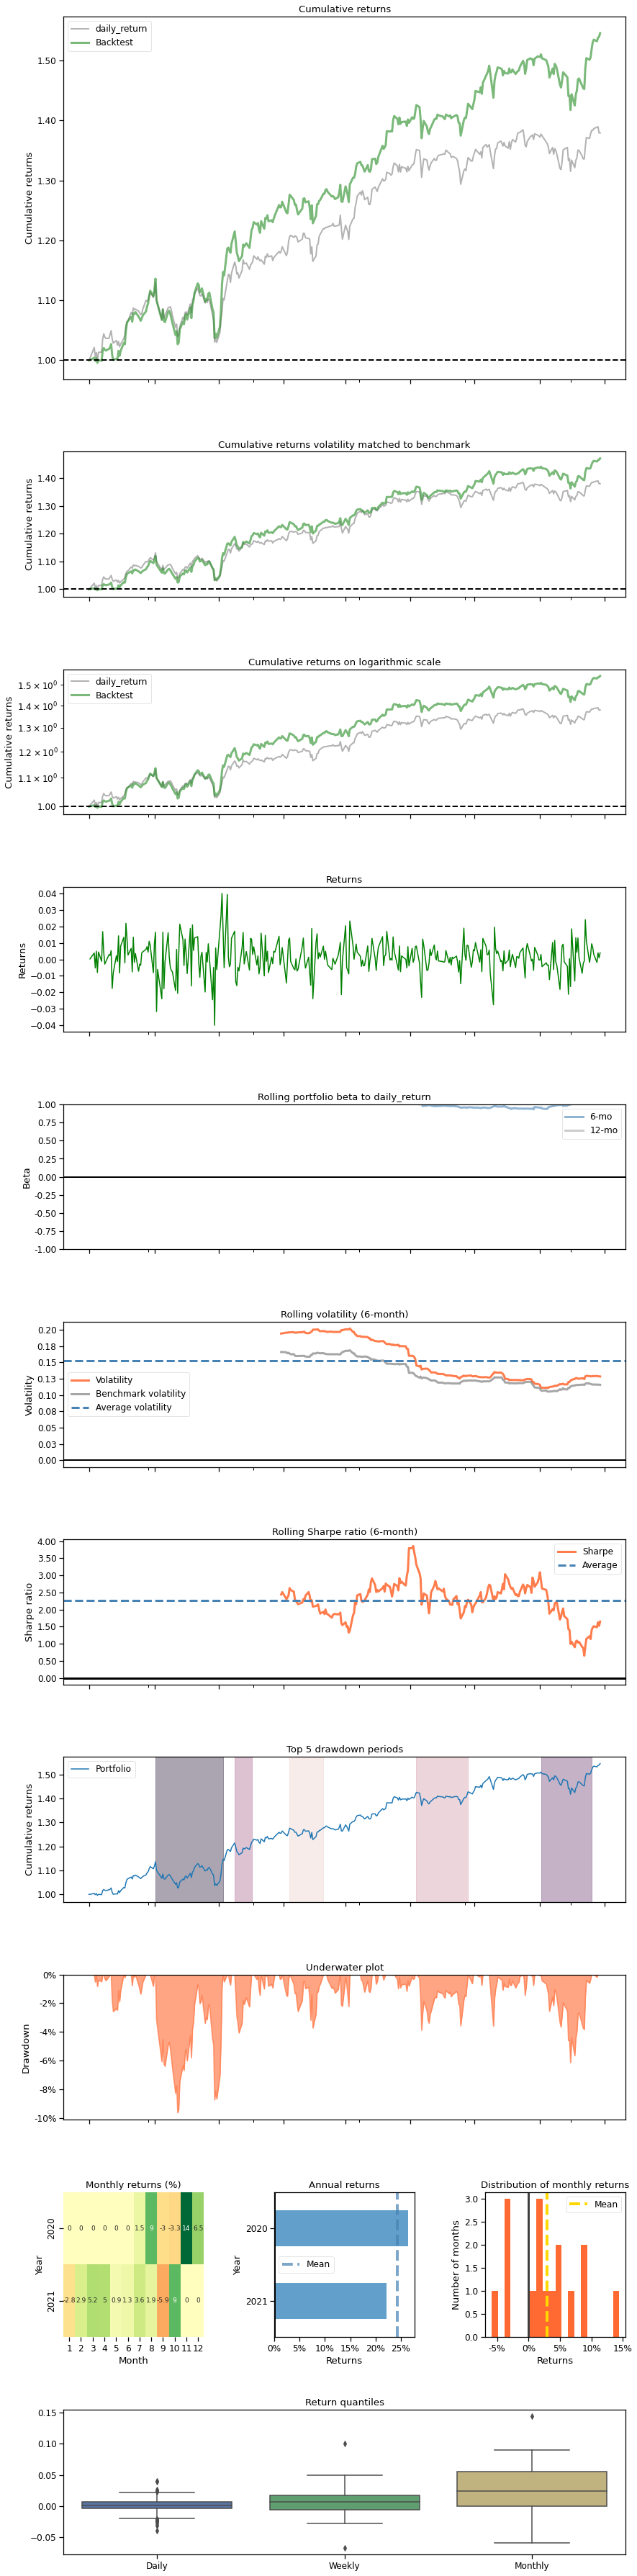

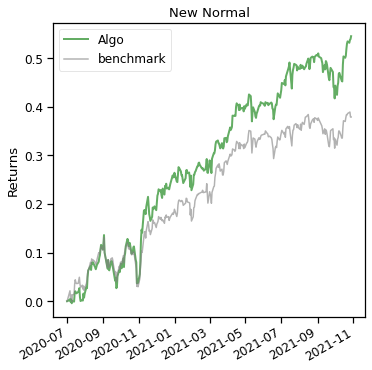

In [37]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])